In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soumikrakshit/anime-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [33]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tqdm import trange
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
import seaborn as sns
import torchvision
sns.set()

In [3]:
os.listdir('/kaggle/input/')

['data']

In [4]:
data_dir = '/kaggle/input/data'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((80, 80))
])

In [6]:
dataset = ImageFolder(data_dir, transform = transform)

In [7]:
print(len(dataset))

21551


In [8]:
train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.2)
valid_size = len(dataset) - train_size - test_size

In [9]:
print(f'Size of train set: {train_size}')
print(f'Size of test set: {test_size}')
print(f'Size of validation set: {valid_size}')

Size of train set: 15085
Size of test set: 4310
Size of validation set: 2156


In [10]:
train_dataset, temp_dataset = random_split(dataset, [train_size, valid_size + test_size])

In [11]:
test_dataset, valid_dataset = random_split(temp_dataset, [test_size, valid_size])

In [12]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)

In [13]:
for x, y in train_loader:
    print(f'Shape of X[N, C, H, W]: {x.shape}')
    break

Shape of X[N, C, H, W]: torch.Size([64, 3, 80, 80])


In [14]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')
print(f'Using {device} device')

Using cuda device


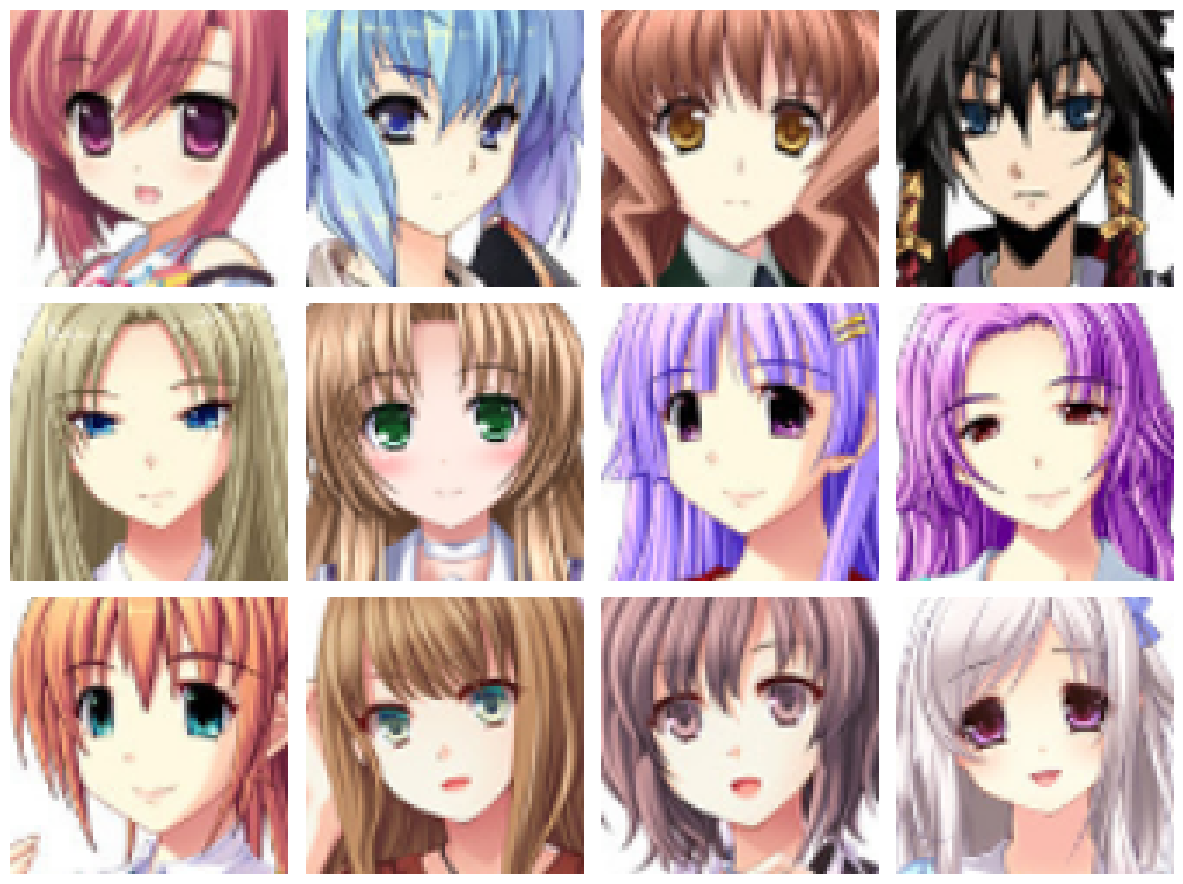

In [15]:
images = []
for i, (img, label) in enumerate(dataset):
    if i >= 12:
        break
    images.append(img)
fig, axes = plt.subplots(3, 4, figsize = (12, 9))
axes = axes.flatten()
for i, img in enumerate(images):
    np_img = img.numpy().transpose(1, 2, 0)
    np_img = np.clip(np_img, 0, 1)
    axes[i].imshow(np_img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(80 * 80 * 3, 400)
        self.fc2_mu = nn.Linear(400, 10)
        self.fc2_logvar = nn.Linear(400, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 80 * 80)
        h1 = F.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 400)
        self.fc2 = nn.Linear(400, 80 * 80 * 3)

    def forward(self, z):
        h1 = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h1))
        return x_recon.view(-1, 3, 80, 80)

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        logvar = torch.clamp(logvar, min=-10, max=10)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [22]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [29]:
n_epochs = 10

In [30]:
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device).float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction = 'sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1} / {n_epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}')

Epoch 1 / 10, Loss: 10420.6738
Epoch 2 / 10, Loss: 10417.5072
Epoch 3 / 10, Loss: 10414.2219
Epoch 4 / 10, Loss: 10412.8835
Epoch 5 / 10, Loss: 10410.0937
Epoch 6 / 10, Loss: 10406.0252
Epoch 7 / 10, Loss: 10402.4469
Epoch 8 / 10, Loss: 10404.2680
Epoch 9 / 10, Loss: 10396.0079
Epoch 10 / 10, Loss: 10396.9775


In [31]:
with torch.no_grad():
    z = torch.randn(64, 10)
    z = z.to(device)
    generated = model.decoder(z)

In [35]:
grid = torchvision.utils.make_grid(generated, nrow = 8, padding = 2, normalize = True)

In [38]:
npimg = grid.cpu().numpy()

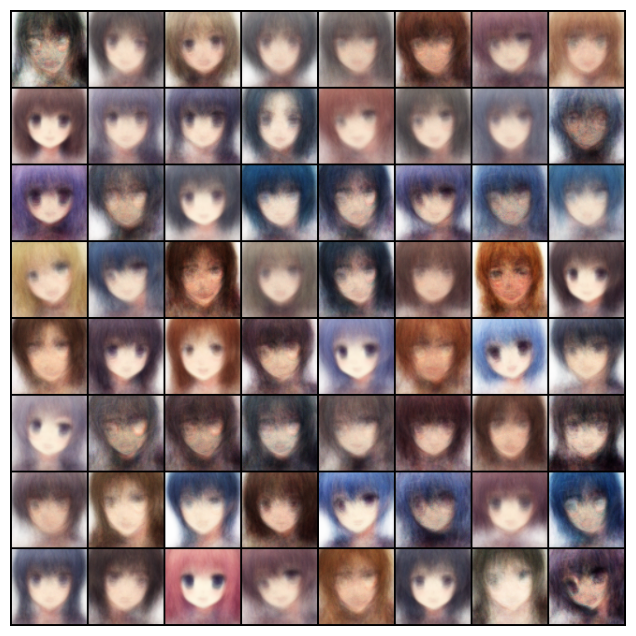

In [39]:
plt.figure(figsize = (8, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()